# 1. Загрузка и подготовка данных

Первым шагом настроим окружение: импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

Сохраним в переменных data с индексом региона входные данные по скважинам. Для каждого региона выведем первые 5 строк массива данных и просмотрим информацию о типах данных таблиц.

In [2]:
data_0 = pd.read_csv('/datasets/geo_data_0.csv')
data_1 = pd.read_csv('/datasets/geo_data_1.csv')
data_2 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
dataset=[data_0, data_1, data_2]
for data in dataset:
    display(data.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
for data in dataset:
    display(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

Построим диаграммы размаха значений объемов запасов в скважине для каждого региона разведки, просмотрим наличие выбросов в данных.

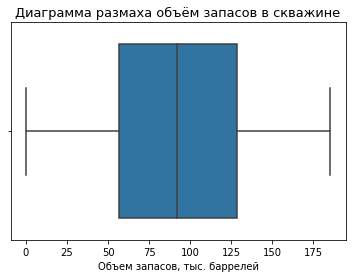

count    100000.000000
mean         92.500000
std          44.288691
min           0.000000
25%          56.497507
50%          91.849972
75%         128.564089
max         185.364347
Name: product, dtype: float64

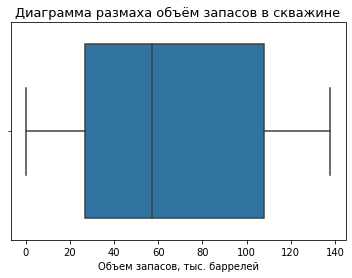

count    100000.000000
mean         68.825000
std          45.944423
min           0.000000
25%          26.953261
50%          57.085625
75%         107.813044
max         137.945408
Name: product, dtype: float64

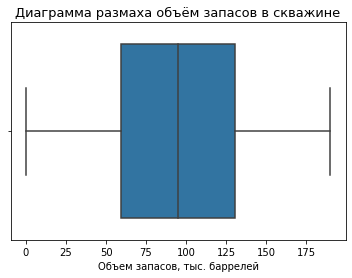

count    100000.000000
mean         95.000000
std          44.749921
min           0.000000
25%          59.450441
50%          94.925613
75%         130.595027
max         190.029838
Name: product, dtype: float64

In [5]:
for data in dataset:
    sns.boxplot(data['product'])
    plt.title('Диаграмма размаха объём запасов в скважине', size=13)
    plt.xlabel('Объем запасов, тыс. баррелей')
    plt.show()

    display(data['product'].describe())

In [6]:
for data in dataset:
    print(data['id'].duplicated().sum())

10
4
4


В предоставленных данных есть дублирующие уникальные идентификаторы скважин, для которых значения признаков (f1, f2, f3) и объём запасов в скважине отличаются. Поскольку у нас нет возможности уточнить данные и их количество мало, оставим данные без изменений.

Создадим переменные для признаков и целевого признака (product — объём запасов в скважине (тыс. баррелей)) для каждого набора данных.

In [7]:
target_0 = data_0['product']
features_0 = data_0.drop(['id', 'product'], axis=1)

target_1 = data_1['product']
features_1 = data_1.drop(['id', 'product'], axis=1)

target_2 = data_2['product']
features_2 = data_2.drop(['id', 'product'], axis=1)

### Вывод
Во входных данных предоставлена информация геологоразведки пробы нефти в трёх регионах с записями о 10000 скважинах, которые характеризуются тремя признаками: f0, f1, f2. Целевым признаком является product — объём запасов в скважине (тыс. баррелей). Выбросы в данных геологоразведки для всех регионов не наблюдается.

# 2. Обучение и проверка модели

Создадим функцию для разделения данных на обучающую и валидационную выборки в соотношении 75:25 и применим ее для каждого региона.

In [8]:
def data_split(features, target):
    features_train, features_valid, target_train, target_valid = train_test_split\
    (features, target, test_size=0.25, random_state=12345)
    # выведем размеры для обучающей и валидационной выборок после разделения
    print(features_train.shape)
    print(target_train.shape)
    print(features_valid.shape)
    print(target_valid.shape)
    # возвращаем данные для признаков и целевого признака для обучающей и валидационной выборок
    return features_train, features_valid, target_train, target_valid

In [9]:
# разделим данные для 0 региона
features_train_0, features_valid_0, target_train_0, target_valid_0 = data_split(features_0, target_0)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [10]:
# разделим данные для 1 региона
features_train_1, features_valid_1, target_train_1, target_valid_1 = data_split(features_1, target_1)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


In [11]:
# разделим данные для 2 региона
features_train_2, features_valid_2, target_train_2, target_valid_2 = data_split(features_2, target_2)

(75000, 3)
(75000,)
(25000, 3)
(25000,)


Для каждого региона обучим модель линейной регрессии и проверим предсказания на валидационной выборке. В модели линейной регрессии укажем агрумент normalize=True для нормализации численных признаков.

In [12]:
def model_predict(features_train, target_train, features_valid, target_valid):
    model = LinearRegression(normalize=True)
    model.fit(features_train, target_train)
    predict_valid = model.predict(features_valid)
    product_pred_mean = predict_valid.mean()
    print('Средний запас предсказанного сырья', product_pred_mean)
    mse = mean_squared_error(target_valid, predict_valid)
    
    # проверим качество модели с помощью коэффициента детерминации
    print('RMSE модели =', mse**0.5)
    print("R2 =", r2_score(target_valid, predict_valid))
    return predict_valid

Сохраним предсказания модели линейной регрессии на валидационной выборке в переменных predict_valid_x, где x - индекс региона разведки.

In [13]:
predict_valid_0 = model_predict(features_train_0, target_train_0, features_valid_0, target_valid_0)

Средний запас предсказанного сырья 92.59256778438035
RMSE модели = 37.5794217150813
R2 = 0.27994321524487786


In [14]:
predict_valid_1 = model_predict(features_train_1, target_train_1, features_valid_1, target_valid_1)

Средний запас предсказанного сырья 68.72854689544602
RMSE модели = 0.8930992867756158
R2 = 0.9996233978805127


In [15]:
predict_valid_2 = model_predict(features_train_2, target_train_2, features_valid_2, target_valid_2)

Средний запас предсказанного сырья 94.96504596800489
RMSE модели = 40.02970873393434
R2 = 0.20524758386040443


### Вывод:
Средний запас предсказанного сырья с помощью модели линейной регрессии в регионах 0, 1, 2 составляет: 92.6, 68.7, 95.0 тыс.баррелей, соответственно. С наилучшим качеством предсказаний используемая модель работает для 1 региона; RMSE модели составляет 0.89, коэффициент детерминации R2 = ~1. Для остальных регионов качество модели хуже, однако метрика R2 положительная и составлет 0.2 и 0.3 для 2 и 0 региона, соответственно.

# 3. Подготовка к расчёту прибыли

In [16]:
total_wells = 500
advanced_wells = 200
region_budget = 10**10
barrel_value = 450000

Рассчитайте достаточный объём сырья для безубыточной разработки новой скважины (breakeven_product). Для этого разделим бюджет на разработку скважин в регионе на количество скважин для разработки и на доход с каждой единицы продукта.

In [17]:
breakeven_product = region_budget / advanced_wells / barrel_value
print('Достаточный объём сырья для безубыточной разработки скважины составляет: {:.1f} тыс.баррелей'.\
      format(breakeven_product))

Достаточный объём сырья для безубыточной разработки скважины составляет: 111.1 тыс.баррелей


### Вывод:
Видно, что средний запас предсказанного сырья в каждом регионе ниже объема для безубыточной разработки. На следующем этапе с помощью машинного обучения необходимо выбрать 200 точек с самыми высокими оценками значений предсказанного для разработки.

# 4. Расчёт прибыли и рисков 

Создадим функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели для каждого региона разведки.

In [18]:
def calc_revenue(target, predict):
    predict_sorted = predict.sort_values(ascending=False)
    selected = target[predict_sorted.index][:advanced_wells]
    product_sum = selected.sum()
    return product_sum * barrel_value - region_budget

Применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли. Рассчитаем среднюю прибыль, 95%-й доверительный интервал и риск убытков для каждого региона. 

In [19]:
state = np.random.RandomState(12345)

def revenue_bootstrap(target, predict):
    predict = pd.Series(predict, index = target.index)
    values = []
    for i in range(1000):
        predict_subsample = predict.sample(n=total_wells, replace=True, random_state=state)
        target_subsample = target[predict_subsample.index]
    
        values.append(calc_revenue(target_subsample, predict_subsample))
    
    values = pd.Series(values)
    mean = values.mean() / 10**6
    lower = values.quantile(0.025) / 10**6
    upper = values.quantile(0.975) / 10**6
    
    print('Возможная средняя прибыль при разработке скважин в регионе составляет {:.2f} млн.руб.'.format(mean))
    print('95%-ый доверительный интервал возможной прибыли: ({:.2f} - {:.2f}) млн.руб.'.format(lower, upper))
    
    
    # рассчитаем риски убытков
    values_loss = values[values<=0].count()
    
    loss_probability = values_loss/len(values)
    
    print('Возможный риск убытков при разработке скважин в регионе составляет {:.1%}'.\
          format(loss_probability))

In [20]:
# выведем показатели для 0 региона
revenue_bootstrap(target_valid_0, predict_valid_0)

Возможная средняя прибыль при разработке скважин в регионе составляет 425.94 млн.руб.
95%-ый доверительный интервал возможной прибыли: (-102.09 - 947.98) млн.руб.
Возможный риск убытков при разработке скважин в регионе составляет 6.0%


In [21]:
# выведем показатели для 1 региона
revenue_bootstrap(target_valid_1, predict_valid_1)

Возможная средняя прибыль при разработке скважин в регионе составляет 518.26 млн.руб.
95%-ый доверительный интервал возможной прибыли: (128.12 - 953.61) млн.руб.
Возможный риск убытков при разработке скважин в регионе составляет 0.3%


In [22]:
# выведем показатели для 2 региона
revenue_bootstrap(target_valid_2, predict_valid_2)

Возможная средняя прибыль при разработке скважин в регионе составляет 420.19 млн.руб.
95%-ый доверительный интервал возможной прибыли: (-115.85 - 989.63) млн.руб.
Возможный риск убытков при разработке скважин в регионе составляет 6.2%


### Вывод:
На основе предсказаний машинного обучения можно сделать предположение, что наиболее перспективным регионом для разработки скважин является регион с данными геологоразведки geo_data_1. По сравнению с другими регионами для него характерна наибольшаяя возможная средняя прибыль (~ 518 млн.руб.) и наиболее ниpкий риск убытков (~ 0.3%). Для остальных регионов показатели возможной средней прибыли и риска убытков при разработке примерно равны и составляют ~420-425 млн.руб. и ~6%, соответственно.